# Scan the base GRN peaks for TF motifs
**Authorship:** Adam Klie (last updated: 08/15/2023)<br>
***
**Description:** This notebook preprocesses 

# Set-up

In [1]:
# Global imports
import os
import sys
import shutil
import importlib
import glob
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Local imports
sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs

# CellOracle imports
import celloracle as co
from celloracle import motif_analysis as ma
from celloracle.utility import save_as_pickled_object

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(

0.14.0


In [ ]:
# Notebook settings
%matplotlib inline

In [ ]:
# Dataset
dataset_name = "igvf_sc-islet_10X-Multiome"
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/celloracle/results"

# Inputs
in_analysis = "base_grn_construction"
in_date = "10Aug23"
in_dir = os.path.join(results_dir, dataset_name, in_date, in_analysis)
print(in_dir)

# Outputs
out_analysis = "base_grn_construction"
out_date = "10Aug23"
out_dir = os.path.join(results_dir, dataset_name, out_date, out_analysis)
make_dirs(out_dir)

In [ ]:
# Make and log a yaml file with the parameters
data_params = {
    "dataset_name": dataset_name,
    "results_dir": results_dir,
    "in_analysis": in_analysis,
    "in_date": in_date,
    "in_dir": in_dir,
    "out_analysis": out_analysis,
    "out_date": out_date,
    "out_dir": out_dir,
}
version_params = {
    "Python": sys.version[:5],
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "scanpy": sc.__version__,
    "seaborn": sns.__version__,
    "celloracle": co.__version__,
}
params = {"data": data_params, "versions": version_params}
if not os.path.exists(os.path.join(out_dir, "tf_motif_scan_params.yaml")):
    with open(os.path.join(out_dir, "tf_motif_scan_params.yaml"), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

In [3]:
# Run once to load the genome you want
#import genomepy
#genomepy.install_genome(name="hg38", provider="UCSC")

In [4]:
# PLEASE make sure reference genome is correct.
ref_genome = "hg38"

genome_installation = ma.is_genome_installed(
    ref_genome=ref_genome,
    genomes_dir=None
)
print(ref_genome, "installation: ", genome_installation)

hg38 installation:  True


In [7]:
# Read in the peaks with their co-accessible gene
peaks = pd.read_csv(os.path.join(out_dir, "processed_peak_file.csv"), index_col=0)
print(len(peaks))
peaks.head()

31140


,peak_id,gene_short_name
0,chr10_100009436_100010350,DNMBP
1,chr10_100081010_100082022,CPN1
2,chr10_100185574_100186492,ERLIN1
3,chr10_100229112_100229961,CHUK
4,chr10_100267214_100268148,CWF19L1


In [18]:
peaks.sort_values("peak_id")

,peak_id,gene_short_name
0,chr10_100009436_100010350,DNMBP
1,chr10_100081010_100082022,CPN1
2,chr10_100185574_100186492,ERLIN1
3,chr10_100229112_100229961,CHUK
4,chr10_100267214_100268148,CWF19L1
...,...,...
31135,chrY_4999812_5000682,PCDH11Y
31136,chrY_5000697_5001440,PCDH11Y
31137,chrY_6910276_6911213,TBL1Y
31138,chrY_7272200_7273051,PRKY


In [25]:
peaks[peaks["peak_id"] == "chr10_102132480_102133402"]

,peak_id,gene_short_name
52,chr10_102132480_102133402,NFKB2
53,chr10_102132480_102133402,PPRC1


In [21]:
peaks[peaks["peak_id"].duplicated()]["peak_id"]

17       chr10_100986907_100987841
21       chr10_101030748_101031675
29       chr10_101228199_101229145
35       chr10_101587750_101588678
53       chr10_102132480_102133402
                   ...            
31088       chrX_80334876_80335788
31091       chrX_81201571_81202522
31103       chrX_91434407_91435325
31105       chrX_93673103_93674108
31134         chrY_3001977_3004457
Name: peak_id, Length: 6818, dtype: object

In [8]:
# Check the peaks
peaks = ma.check_peak_format(peaks, ref_genome, genomes_dir=None)

Peaks before filtering:  31140
Peaks with invalid chr_name:  0
Peaks with invalid length:  0
Peaks after filtering:  31140


In [9]:
# Instantiate TFinfo object
tfi = ma.TFinfo(
    peak_data_frame=peaks,
    ref_genome=ref_genome,
    genomes_dir=None
)

In [26]:
print(len(tfi.all_peaks))
print(len(tfi.all_target_gene))

24322
19395


In [27]:
%%bash
NEW_CACHE=$TMPDIR/cache
mkdir -p $NEW_CACHE
if [ -z $XDG_CACHE_HOME ]; then
    XDG_CACHE_HOME=$HOME/.cache
fi
cp -r $XDG_CACHE_HOME/gimmemotifs $NEW_CACHE/
export XDG_CACHE_HOME=$NEW_CACHE
echo 'Using $XDG_CACHE_HOME for cache'

Using $XDG_CACHE_HOME for cache


In [28]:
!echo $XDG_CACHE_HOME

In [29]:
# Scan motifs. This step may take several hours if you have many peaks!
tfi.scan(
    fpr=0.02,
    motifs=None,  # If you enter None, default motifs will be loaded.
    verbose=True
)

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



DEBUG:gimme.scanner:using background: genome hg38 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



scanning:   0%|          | 0/24322 [00:00<?, ? sequences/s]

DEBUG:gimme.scanner:Scanning


In [30]:
# Save tfinfo object
tfi.to_hdf5(file_path=os.path.join(out_dir, "default.celloracle.tfinfo"))

In [31]:
# Check motif scan results
tfi.scanned_df.head()

,seqname,motif_id,factors_direct,factors_indirect,score,pos,strand
0,chr10_100009436_100010350,GM.5.0.Mixed.0001,,"EGR1, SRF",8.555754,360,-1
1,chr10_100009436_100010350,GM.5.0.Mixed.0001,,"EGR1, SRF",8.297692,619,-1
2,chr10_100009436_100010350,GM.5.0.Mixed.0001,,"EGR1, SRF",7.898092,727,-1
3,chr10_100009436_100010350,GM.5.0.Mixed.0001,,"EGR1, SRF",7.659488,728,-1
4,chr10_100009436_100010350,GM.5.0.Mixed.0001,,"EGR1, SRF",7.555011,356,-1


In [32]:
tfi.scanned_df["motif_id"].value_counts()

GM.5.0.Unknown.0089        291486
GM.5.0.C2H2_ZF.0099        242154
GM.5.0.Unknown.0132        224175
GM.5.0.bHLH.0125           193604
GM.5.0.Mixed.0001          184587
                            ...  
GM.5.0.C2H2_ZF.0090           484
GM.5.0.Homeodomain.0104       474
GM.5.0.bHLH.0112              458
GM.5.0.DM.0002                407
GM.5.0.C2H2_ZF.0076           398
Name: motif_id, Length: 1581, dtype: int64

In [37]:
# Reset filtering
tfi.reset_filtering()

In [40]:
%matplotlib inline

<AxesSubplot: ylabel='Frequency'>

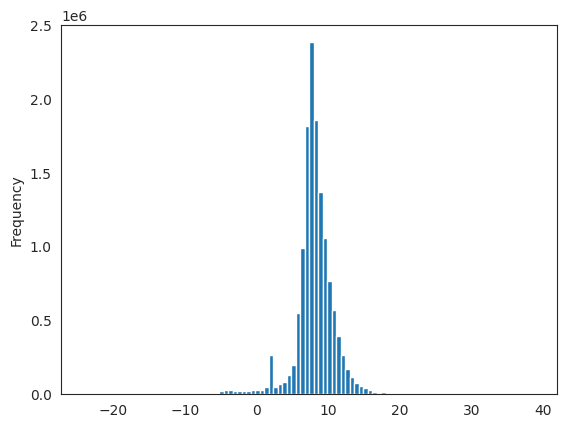

In [41]:
tfi.scanned_df.score.plot(kind="hist", bins=100)

In [43]:
# Do filtering
tfi.filter_motifs_by_score(threshold=10)

Filtering finished: 13782369 -> 2785049


In [52]:
tfi.scanned_filtered

,seqname,motif_id,score
0,chr10_100009436_100010350,GM.5.0.AP-2.0002,31.926771
1,chr10_100009436_100010350,GM.5.0.AP-2.0005,16.401812
2,chr10_100009436_100010350,GM.5.0.AP-2.0006,51.536958
3,chr10_100009436_100010350,GM.5.0.AP-2.0009,18.944543
4,chr10_100009436_100010350,GM.5.0.C2H2_ZF.0001,11.312499
...,...,...,...
2785044,chrY_7273541_7274654,GM.5.0.bHLH.0125,162.627411
2785045,chrY_7273541_7274654,GM.5.0.bZIP.0020,16.444835
2785046,chrY_7273541_7274654,GM.5.0.bZIP.0060,28.014758
2785047,chrY_7273541_7274654,GM.5.0.bZIP.0093,151.501470


In [48]:
# Format post-filtering results.
tfi.make_TFinfo_dataframe_and_dictionary(verbose=True)

1. Converting scanned results into one-hot encoded dataframe.


  0%|          | 0/24322 [00:00<?, ?it/s]

2. Converting results into dictionaries.


  0%|          | 0/19395 [00:00<?, ?it/s]

  0%|          | 0/1095 [00:00<?, ?it/s]

In [49]:
# Make a dataframe from this
df = tfi.to_dataframe()
df.head()

,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100009436_100010350,DNMBP,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr10_100081010_100082022,CPN1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,chr10_100185574_100186492,ERLIN1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr10_100229112_100229961,CHUK,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,chr10_100267214_100268148,CWF19L1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [53]:
df.shape

(31140, 1097)

In [55]:
df.iloc[:, 2:].sum(axis=0).sort_values(ascending=False).iloc[:50]

EGR1       26684
SP2        25844
SP5        25801
SP1        25683
E2F1       25493
E2F4       25380
PAX5       25256
SP3        25233
NRF1       25030
SP9        24957
SP8        24904
THAP1      24892
ELF1       24769
YY1        24411
EP300      24385
ATF3       24353
SP7        24275
SP6        24195
TAF1       23478
ZBTB7A     23327
ZNF143     23263
TCFAP2D    23257
TFAP2E     23257
ZBTB33     23160
SP4        23112
BCLAF1     22833
E2F3       22817
GABPA      22715
TFDP1      22631
HEY1       22545
TFAP2A     22489
TFAP2B     22361
KLF6       22343
TFAP2C     22341
RXRA       22275
NR3C1      22206
E2F6       22167
KLF7       21860
TCFAP2A    21849
WT1        21757
ZBTB14     21744
SIN3A      21664
E2F2       21636
NFE2       21576
MAZ        21564
IRF1       21532
FOXA1      21494
ETS1       21452
KLF5       21397
KLF3       21397
dtype: int64

In [50]:
# Save result as a dataframe
df.to_parquet(os.path.join(out_dir, "base_GRN_dataframe.parquet"))

In [61]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()

In [63]:
base_GRN

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91971,chrX_99839037_99840900,Phka1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
91972,chrY_345823_347369,Eif2s3y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91973,chrY_581272_582790,Uty,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91974,chrY_621772_623366,Ddx3y,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
tfi.dic_peak2Targetgene

{'chr10_99917681_99918719': 'DNMBP',
 'chr10_99930479_99931443': 'DNMBP',
 'chr10_99931690_99932548': 'DNMBP',
 'chr10_99913513_99914504': 'DNMBP',
 'chr10_100009436_100010350': 'DNMBP',
 'chr10_100081010_100082022': 'CPN1',
 'chr10_100185574_100186492': 'ERLIN1',
 'chr10_100229112_100229961': 'CHUK',
 'chr10_100267214_100268148': 'CWF19L1',
 'chr10_100286047_100287028': 'BLOC1S2',
 'chr10_100330597_100331555': 'PKD2L1',
 'chr10_100346395_100347354': 'SCD',
 'chr10_100373056_100373943': 'OLMALINC',
 'chr10_100519069_100520043': 'SEC31B',
 'chr10_100529405_100530323': 'NDUFB8',
 'chr10_100535422_100536351': 'HIF1AN',
 'chr10_100745055_100745881': 'PAX2',
 'chr10_100735131_100736110': 'PAX2',
 'chr10_100912452_100913308': 'SLF2',
 'chr10_100971042_100971991': 'SEMA4G',
 'chr10_100986907_100987841': 'TWNK',
 'chr10_100996964_100998300': 'LZTS2',
 'chr10_100999084_101000034': 'LZTS2',
 'chr10_101030748_101031675': 'SFXN3',
 'chr10_101031974_101032899': 'SFXN3',
 'chr10_101060549_101061501'

In [64]:
tfi.dic_targetgene2TFs

{'DNMBP': array(['AL662824.5', 'AL662830.5', 'AL662833.4', 'AL773544.1',
        'AL844527.7', 'AL845464.3', 'AP2ALPHA', 'AR', 'ARID2', 'ARNT',
        'ARNTL', 'ARNTL2', 'ATF3', 'ATF5', 'ATOH8', 'BACH1', 'BACH2',
        'BATF', 'BCL11A', 'BCL11B', 'BCL3', 'BCL6', 'BCL6B', 'BCLAF1',
        'BDP1', 'BHLHB2', 'BHLHB3', 'BHLHE40', 'BHLHE41', 'BMAL1', 'BRCA1',
        'BRF1', 'BRF2', 'BX088580.2', 'BX284686.1', 'BX927239.6', 'CCNT2',
        'CEBPB', 'CHD2', 'CLOCK', 'CMYC', 'CR354565.3', 'CR388229.2',
        'CR759733.4', 'CR759815.4', 'CR812478.2', 'CR933878.8',
        'CR936877.3', 'CREB1', 'CTCF', 'CTCFL', 'DLX5', 'E2F1', 'E2F2',
        'E2F3', 'E2F4', 'E2F5', 'E2F6', 'E2F7', 'EBF1', 'EGR', 'EGR1',
        'EGR2', 'EGR4', 'EHF', 'ELF1', 'ELF2', 'ELK1', 'ELK3', 'ELK4',
        'ENO1', 'ENSG00000235187', 'ENSG00000250096', 'ENSG00000250811',
        'ENSMUSG00000044690', 'ENSMUSG00000079994', 'ENSMUSG00000090020',
        'EP300', 'ERF', 'ERG', 'ESR1', 'ESRRA', 'ETS1', 'ETS2', 'ETV1

In [62]:
base_GRN.iloc[:, 2:].sum(axis=0).sort_values(ascending=False).iloc[:50]

E2f1       53978.0
Ep300      53529.0
Egr1       53435.0
Sp2        53340.0
Sp5        53108.0
Sp3        53023.0
Pax5       53010.0
Elf1       52980.0
Rxra       52958.0
E2f4       52931.0
Sp9        52600.0
Sp8        52501.0
Sp1        51864.0
Atf3       51669.0
Thap1      51665.0
Sp7        51439.0
Sp6        51361.0
Yy1        51242.0
Klf6       50911.0
Nrf1       50906.0
Klf7       50330.0
Klf3       50229.0
Klf5       50229.0
E2f2       49892.0
E2f3       49780.0
Klf2       49761.0
Sp4        49568.0
Myc        49461.0
Tfdp1      49216.0
Ets1       49179.0
Max        49034.0
Znf143     49032.0
Zbtb33     48865.0
E2f6       48819.0
Nr3c1      48700.0
Tcf12      48644.0
Bclaf1     48631.0
Taf1       48594.0
Hey1       48537.0
Gabpa      48301.0
Zbtb14     48243.0
Zbtb7a     48237.0
Tfap2e     47800.0
Tcfap2d    47800.0
Rest       47146.0
Klf12      47058.0
Tead2      46733.0
Setdb1     46485.0
Bhlhe40    46347.0
Nfe2       46340.0
dtype: float64

In [59]:
base_GRN

,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100027907_100029007,LOXL4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100154964_100156064,MIR1287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr10_100174878_100175978,PYROXD2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_100191017_100192117,MIR4685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_100205078_100206178,LOC101927278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36998,chrY_9558805_9559905,TTTY21B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36999,chrY_9572895_9573995,TTTY2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
37000,chrY_9611828_9612928,TTTY1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37001,chrY_9637762_9638862,TTTY22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# DONE!

---

# Scratch

## Troubleshooting why things got hung at set_background step
https://github.com/vanheeringen-lab/gimmemotifs/blob/master/gimmemotifs/scanner/base.py#L249C17-L249C17

In [ ]:
from gimmemotifs.fasta import Fasta
from gimmemotifs.scanner import Scanner
from gimmemotifs.background import RandomGenomicFasta
from gimmemotifs.config import CACHE_DIR
from diskcache import Cache
from gimmemotifs.utils import as_fasta
from multiprocessing import Lock, Pool

In [ ]:
# Give me a single thread scanner
s = Scanner(ncpus=1)

In [50]:
# Asking is this line the problem?
Fasta("/cellar/users/aklie/.local/share/genomes/hg38/hg38.fa")

194 sequences

In [51]:
# What happens if I just run this
s.set_background(fname="/cellar/users/aklie/.local/share/genomes/hg38/hg38.fa", size=200)

In [58]:
# Asking is this line the problem?
RandomGenomicFasta("hg38.fa", size=200, n=100)

100 sequences

In [63]:
gc_bins = [(0, 1)]
background_hash = "d{}:{}:{}:{}".format("hg38", int(200), False, str(gc_bins))
gc = False
c = cache.get(background_hash)
if c:
    fa, gc_bins = c
else:
    fa = None
if not fa:
    if gc:
        with NamedTemporaryFile() as tmp:
            logger.info(f"using {nseq} sequences")
            gc_bin_bedfile(
                tmp.name, "hg38", 100, 200, gc_bins, 13
            )
            fa = as_fasta(tmp.name, genome="hg38")
    else:
        fa = RandomGenomicFasta("hg38", 200, 100)
    cache.set(background_hash, (fa, gc_bins))

In [81]:
lock = Lock()

In [83]:
lock.acquire()
lock.release()